## Transfer learning with densenet
1. Number of doodle classes are 340. This is quite big, so deep CNN networks are required.
2. But we don't have much resouces and are not able to train such a huge network for a long time.
3. Transfer learning comes in! DenseNet is a useful backbone structure for image recognition and pretrained weights are provided.

I refered to this kernel[https://www.kaggle.com/leighplt/pytorch-starter-kit]

In [1]:
#module import

import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, utils
import copy
import tqdm
import sys

%matplotlib inline

In [2]:
# variables and hyperparameters

train_dir = '../input/train_simplified'
test_dir = '../input'
test_file = 'test_simplified.csv'

train_nrows = 2000
val_nrows = 100

train_files = os.listdir(train_dir)
train_files = sorted(train_files)

w2i_dict = {fn[:-4].replace(' ','_'): i for i, fn in enumerate(train_files)}
i2w_dict = {v: k for k, v in w2i_dict.items()}

In [3]:
# Make training / validation Datasets

class DoodleDataset(Dataset):
    def __init__(self, file, dir, mode='train', nrows = None, skiprows=None, transform = None):
        self.file = file
        self.dir = dir
        self.mode = mode
        self.nrows = nrows
        self.transform = transform
        # only use 'nrows' to reduce memory usage / skiprows is used when we make validation set
        self.pd_frame = pd.read_csv(os.path.join(self.dir, self.file), usecols=['drawing'], nrows=nrows, skiprows=skiprows)
        if self.mode == 'train':
            self.label = w2i_dict[file[:-4].replace(' ','_')]
        
    @staticmethod
    # used in __getitem__ function / converts points into line
    def _point2line(strokes):
        # one channel as a grayscale
        img = np.zeros((256,256), dtype = np.uint8)
        for stroke in strokes:
            x_coords = stroke[0]
            y_coords = stroke[1]
            for i in range(len(stroke[0])-1):
                # draw line in color 255
                cv2.line(img, (x_coords[i], y_coords[i]), (x_coords[i+1], y_coords[i+1]), color = 255, thickness = 2)
        return img
    
    def __len__(self):
        return len(self.pd_frame)
    
    def __getitem__(self, idx):
        # string to type variable
        strokes = eval(self.pd_frame.drawing[idx])
        sample = self._point2line(strokes)
        if self.transform:
            sample = self.transform(sample)
        if self.mode=='train':
            # after transform, return images as a numpy array
            sample = sample.numpy()
            return sample.astype('float32'), self.label
        else:
            # add batch size
            sample = sample.numpy()
            return sample.astype('float32')

        
data_transform = transforms.Compose([
    # numpy ndarray to PIL image
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

val_data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])


doodles = ConcatDataset([DoodleDataset(fn, train_dir, nrows=train_nrows, transform = data_transform) for fn in train_files])
doodles_val = ConcatDataset([DoodleDataset(fn, train_dir, nrows=val_nrows, transform = val_data_transform, skiprows=range(1, train_nrows+1)) for fn in train_files])

In [4]:
# Make dataloader

dataloader = DataLoader(doodles, batch_size = 16, shuffle = True, num_workers = 4)
valloader = DataLoader(doodles_val, batch_size = 16, shuffle = True, num_workers = 4)

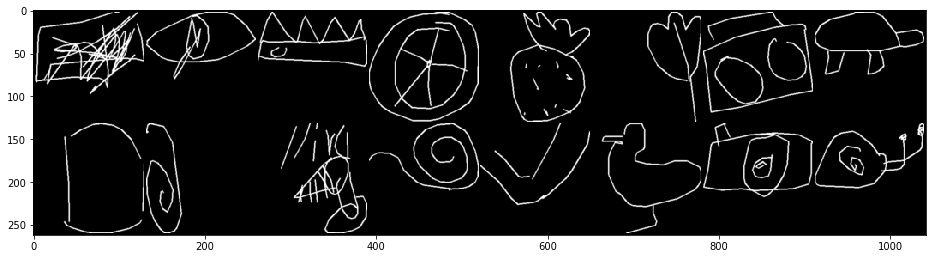

In [5]:
# check if dataset and dataloader are formed well

samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, height, width), so you have to transpose it to (height, width, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [6]:
#score function

def mapk(output, target, k=3):
    with torch.no_grad():
        batch_size = target.size(0)
        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        for i in range(k):
            correct[i] = correct[i]*(k-i)
        score = correct[:k].view(-1).float().sum(0, keepdim=True)
        score.mul_(1.0 / (k * batch_size))
        return score

In [7]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(RAdam, self).__init__(params, defaults)

        # step_buffer stores [step, N_sma, step_size]
        self.step_buffer = [None, None, None]
        self.N_sma_max = 2 / (1-betas[1]) -1

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):
        loss = None if closure is None else closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # basic variables
                p_data_fp32 = p.data.float()
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 1
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['step'] += 1
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)
                
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                beta1_t, beta2_t = beta1 ** state['step'], beta2 ** state['step']
                bias_correction1, bias_correction2 = 1 - beta1_t, 1 - beta2_t

                # get gradients
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')    

                # update exponential average and exponential average squared
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # get N_sma and store in step_buffer
                if state['step'] == self.step_buffer[0]:
                    N_sma, step_size = self.step_buffer[1], self.step_buffer[2]
                else:
                    N_sma = self.N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    # step size reflects rectification and bias_correction term in advance
                    if N_sma >= 5:
                        rectification = math.sqrt( ((N_sma-4)*(N_sma-2)*self.N_sma_max) / ((self.N_sma_max-4)*(self.N_sma_max-2)*N_sma) )
                        step_size = math.sqrt(bias_correction2) * rectification / bias_correction1
                    else:
                        step_size = 1.0 / bias_correction1
                    
                    self.step_buffer[0] = state['step']
                    self.step_buffer[1] = N_sma
                    self.step_buffer[2] = step_size

                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # update parameter
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


In [8]:
# transfer learning with densenet121 structure

device = 'cuda'

# densenet input image is RGB channel color image, so you have to reduce channel
def squeeze_weights(m):
    m.weight.data = m.weight.data.sum(dim=1)[:,None]
    m.in_channels = 1
model = torchvision.models.densenet121(pretrained=True)    

'''
if you have small portion of data, only training classifier is a good way.
for param in model.parameters():
    param.requires_grad = False
'''
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 340)
model.features.conv0.apply(squeeze_weights)


model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = RAdam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30000,60000,90000], gamma=0.3)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /tmp/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 76.4MB/s]


In [9]:
# Training procedure

epochs = 3
itr = 1
p_itr = 5000
total_loss, score = 0,0
val_score = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
best_score = 0.0
loss_list = []
score_list = []


for epoch in range(epochs):
    model.train()
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)    
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        score += mapk(output, labels)[0].item()
        scheduler.step()
        
        if itr%p_itr==0:
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, MAP@3: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, score/p_itr))
            loss_list.append(total_loss/p_itr)
            score_list.append(score/p_itr)
            total_loss, score = 0,0
        itr += 1
        
    # use validation set for finding well updated weights
    model.eval()
    for samples, labels in valloader:
        with torch.no_grad():
            samples = samples.to(device)
            labels = labels.to(device)
            output = model(samples)
            val_score += mapk(output, labels)[0].item()
    print('[Epoch {}/{}] Validation Score: {:.4f}'.format(epoch+1, epochs, val_score/len(valloader)))
    if val_score > best_score:
        best_score = val_score
        best_model_wts = copy.deepcopy(model.state_dict())
    val_score = 0
    
    
# best performed weights are chosen
model.load_state_dict(best_model_wts)

[Epoch 1/3] Iteration 5000 -> Train Loss: 3.0861, MAP@3: 0.172
[Epoch 1/3] Iteration 10000 -> Train Loss: 2.0953, MAP@3: 0.237
[Epoch 1/3] Iteration 15000 -> Train Loss: 1.8281, MAP@3: 0.254
[Epoch 1/3] Iteration 20000 -> Train Loss: 1.6848, MAP@3: 0.263
[Epoch 1/3] Iteration 25000 -> Train Loss: 1.5724, MAP@3: 0.269
[Epoch 1/3] Iteration 30000 -> Train Loss: 1.5138, MAP@3: 0.272
[Epoch 1/3] Iteration 35000 -> Train Loss: 1.3280, MAP@3: 0.282
[Epoch 1/3] Iteration 40000 -> Train Loss: 1.2724, MAP@3: 0.285
[Epoch 1/3] Validation Score: 0.2892
[Epoch 2/3] Iteration 45000 -> Train Loss: 1.2186, MAP@3: 0.287
[Epoch 2/3] Iteration 50000 -> Train Loss: 1.1849, MAP@3: 0.289
[Epoch 2/3] Iteration 55000 -> Train Loss: 1.1749, MAP@3: 0.290
[Epoch 2/3] Iteration 60000 -> Train Loss: 1.1600, MAP@3: 0.290
[Epoch 2/3] Iteration 65000 -> Train Loss: 1.1185, MAP@3: 0.292
[Epoch 2/3] Iteration 70000 -> Train Loss: 1.1077, MAP@3: 0.293
[Epoch 2/3] Iteration 75000 -> Train Loss: 1.1135, MAP@3: 0.293
[Epo

<All keys matched successfully>

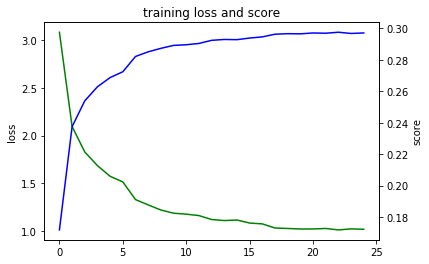

In [10]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_list, label='loss', color = 'g')
ax2.plot(score_list, label='score', color = 'b')

ax1.set_ylabel('loss')
ax2.set_ylabel('score')

plt.title('training loss and score')
plt.show()

In [11]:
filename_pth = 'ckpt_densenet121.pth'
torch.save(model.state_dict(), filename_pth)

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = DoodleDataset(test_file, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=4)

In [12]:
model.eval()
labels = np.empty((0,3))
for x in tqdm.tqdm_notebook(testloader):
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        _, pred = output.topk(3,1,True,True)
        labels = np.concatenate([labels, pred.cpu()], axis=0)
    
submission = pd.read_csv('../input/test_simplified.csv', index_col='key_id')
submission.drop(['countrycode','drawing'], axis=1, inplace=True)
submission['word']=''
for i, label in enumerate(labels):
    submission.word.iloc[i] = " ".join([i2w_dict[l] for l in label])
    
submission.to_csv('preds_densenet121.csv')

In [13]:

from IPython.display import FileLinks
FileLinks('.') # input argument is specified folder


./
  ckpt_densenet121.pth
  preds_densenet121.csv
  __output__.json
  __notebook__.ipynb